# Integrate/aggregate signals across spatial layers

In this notebook, we will describe some usage principles for the *aggregate* method.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext jupyter_black

Please download the data from here: [mouse_liver dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/mouse_liver.zip) and adjust the variable containing the location of the .zarr file.

In [2]:
import spatialdata

/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [3]:
sdata = spatialdata.read_zarr("./mouse_liver.zarr")

print(sdata)

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-sandbox/mouse_liver/data.zarr
├── Images
│     └── 'raw_image': DataTree[cyx] (1, 6432, 6432), (1, 1608, 1608)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (6432, 6432)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     └── 'nucleus_boundaries': GeoDataFrame shape: (3375, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (3375, 99)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), nucleus_boundaries (Shapes)


/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


/opt/miniconda3/envs/ome311/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/miniconda3/envs/ome311/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/miniconda3/envs/ome311/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `Sp

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:115: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


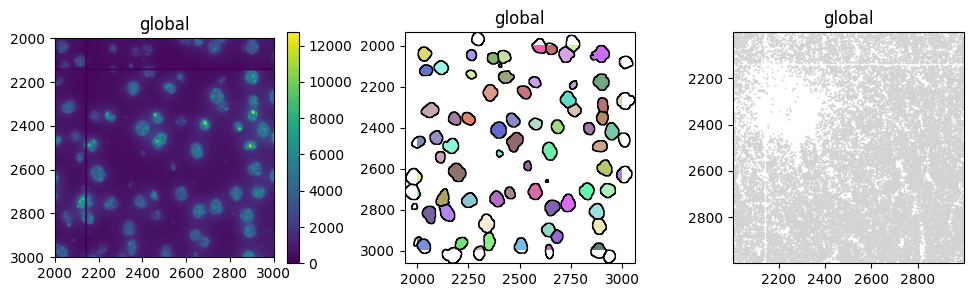

In [4]:
import matplotlib.pyplot as plt


def crop(sdata):
    return sdata.query.bounding_box(
        min_coordinate=[2000, 2000], max_coordinate=[3000, 3000], axes=("x", "y"), target_coordinate_system="global"
    )


fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

crop(sdata).pl.render_images("raw_image").pl.show(ax=axs[0])
crop(sdata).pl.render_labels("segmentation_mask").pl.render_shapes(
    "nucleus_boundaries", fill_alpha=0, outline_alpha=1, outline_width=1
).pl.show(ax=axs[1])
crop(sdata).pl.render_points("transcripts").pl.show(ax=axs[2])

We can do various type of aggregations:
- aggregate *images* by *labels*
- aggregate *points* by *shapes*
- aggregate *shapes* by *shapes*

Aggregations between mixed raster and non-raster types can be performed after manually calling `spatialdata.vectorize()` or `spatialdata.rasterize()`.

The API function for aggregation is `spatialdata.aggregate`. It is also possible to perform aggregation using the convenience method `spatialdata.SpatialData.aggregate`, which simply calls the previous one and automatically fills some values (`values_sdata` and `by_sdata`) with `self`; we will see this below.

## Aggregating images by labels (segmentation mask for nuclei)

In [5]:
sdata_im = sdata.aggregate(values="raw_image", by="segmentation_mask", agg_func="mean")

/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


As default, the aggregation function is `sum` but it can be changed with the `agg_func` parameter. We can inspect the table inside the returned `SpatialData` object to confirm that the operation results in retrieving the mean intensity of each image channel within the boundaries of the labels.
We can also visualize the results with `spatialdata-plot`. By overlaying the labels with the channel where we performed aggregation, we can better appreciate the results. Labels that overlap with high intensity of the channels have indeed a higher mean intensity.

The features of the new table are the following:

In [6]:
sdata_im["table"].var_names

Index(['channel_0_mean'], dtype='object')

/opt/miniconda3/envs/ome311/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


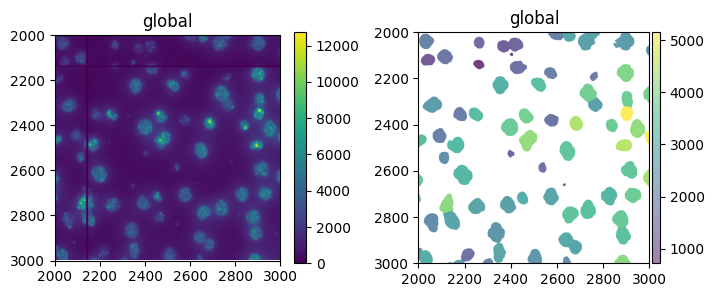

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
crop(sdata).pl.render_images("raw_image", cmap="viridis", channel=0).pl.show(ax=axs[0])
crop(sdata_im).pl.render_labels(color="channel_0_mean", fill_alpha=0.5).pl.show(ax=axs[1])

We can also aggregate points by shapes. For example, let's count the number of points that overlap each shape.


Here we see the points and shapes that we will use for aggregation.

## Aggregating points (transcripts) by shapes (nuclei boundaries)

In [8]:
sdata["transcripts"].compute()

,x,y,gene
0,433.0,1217.0,Adgre1
1,151.0,1841.0,Adgre1
2,139.0,1983.0,Adgre1
3,1349.0,1601.0,Adgre1
4,784.0,1732.0,Adgre1
...,...,...,...
1998863,5743.0,5233.0,Lyve1
1998864,5721.0,4581.0,Lyve1
1998865,5807.0,4842.0,Lyve1
1998866,5843.0,5309.0,Lyve1


In [9]:
some_genes = sdata["transcripts"].gene.cat.as_known().compute().astype("str").unique()[:20].tolist()
some_genes

['Adgre1',
 'Atp6v0d2',
 'Stab2',
 'Spp1',
 'Igfbp3',
 'Lhx6',
 'Grip1',
 'Cx3cr1',
 'Vsig4',
 'F13a1',
 'Epcam',
 'Spn',
 'Itgb7',
 'Mfap4',
 'Pecam1',
 'Siglech',
 'Cd14',
 'Prox1',
 'Mafb',
 'Myh11']

/opt/miniconda3/envs/ome311/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:115: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/proje

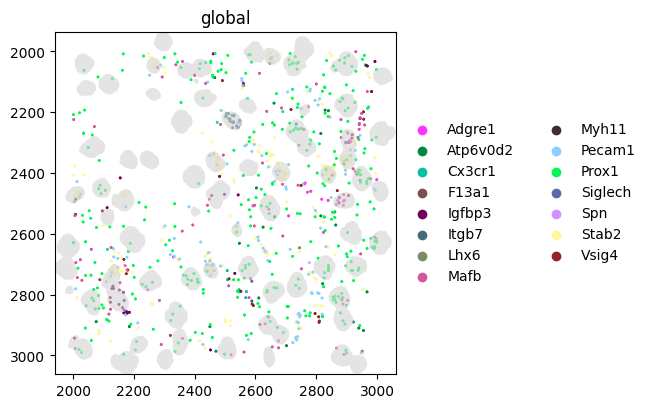

In [10]:
crop(sdata).pl.render_points(color="gene", groups=some_genes).pl.render_shapes(
    "nucleus_boundaries", fill_alpha=0.6
).pl.show()

The `value_key` parameters specifies which columns of the points dataframe will be aggregated.

In [11]:
sdata_shapes = sdata.aggregate(values="transcripts", by="nucleus_boundaries", value_key="gene", agg_func="count")
sdata_shapes

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:453: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated = joined.groupby([INDEX, vk])[ONES_COLUMN].agg(agg_func).reset_index()
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


SpatialData object
├── Shapes
│     └── 'nucleus_boundaries': GeoDataFrame shape: (3375, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (3375, 100)
with coordinate systems:
    ▸ 'global', with elements:
        nucleus_boundaries (Shapes)

Let's color by the `var` value `Adgre1` of the aggregate table (that is, we color by the numbers of points of type `Adgre1` inside each shape).

/opt/miniconda3/envs/ome311/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:115: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/proje

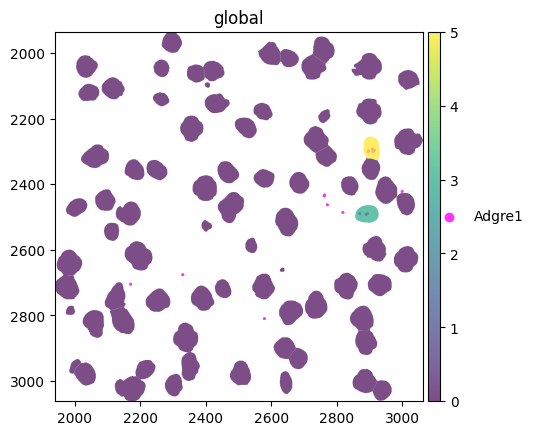

In [12]:
ax = plt.gca()
crop(sdata).pl.render_points(color="gene", groups="Adgre1").pl.show(ax=ax)
crop(sdata_shapes).pl.render_shapes(color="Adgre1", cmap="viridis", fill_alpha=0.7).pl.show(ax=ax)

The colormap represents the number of counts for the selected variable (gene `Adgre1`).

## Aggregating shapes by shapes (coarsing the nuclei into a grid)

Let's create two grids, a checkboard grid and an hexagonal grid. Let's coarse the nuclei into these two grids. The target element for the aggregation doesn't need to be a grid, it could be composed for instance of handdrawn regions of interest.

Here are some simple functions to create some grids, represented as `GeoDataFrame` objects. The grid will span the extend of the data.

### Creating the checkboard grid

Note, here we only have the `global` coordinate system, and all the coordinate transformations are `Identity()`, so in the following we can omit specifying the coordinate system and coordinate transformation informations to `get_extent()` and `ShapesModel.parse()`.

In [13]:
from spatialdata import get_extent

extent = get_extent(sdata)
extent

{'y': (np.float64(0.0), np.float64(6432.0)),
 'x': (np.float64(0.0), np.float64(6432.0))}

In [14]:
import numpy as np
from geopandas import GeoDataFrame
from shapely.geometry import Polygon
from spatialdata.models import ShapesModel


def make_checkboard_grid(x_min: float, x_max: float, y_min: float, y_max: float, n_cells_x, n_cells_y) -> GeoDataFrame:
    x_cell_size = (x_max - x_min) / n_cells_x
    y_cell_size = (y_max - y_min) / n_cells_y

    grid = []
    for x0 in np.arange(x_min, x_max, x_cell_size):
        for y0 in np.arange(y_min, y_max, y_cell_size):
            cell = Polygon(
                [(x0, y0), (x0 + x_cell_size, y0), (x0 + x_cell_size, y0 + y_cell_size), (x0, y0 + y_cell_size)]
            )
            grid.append(cell)

    grid_gdf = GeoDataFrame(grid, columns=["geometry"])
    return ShapesModel.parse(grid_gdf)

<Axes: >

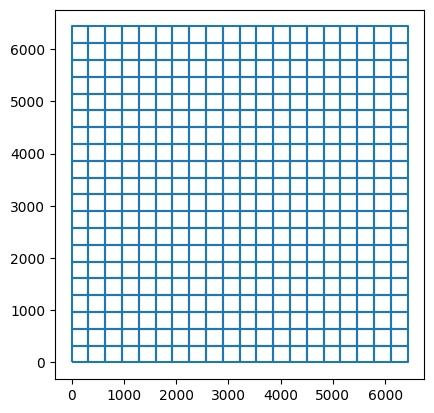

In [15]:
checkboard_grid_gdf = make_checkboard_grid(
    x_min=extent["x"][0].item(),
    x_max=extent["x"][1].item(),
    y_min=extent["y"][0].item(),
    y_max=extent["y"][1].item(),
    n_cells_x=20,
    n_cells_y=20,
)
checkboard_grid_gdf.boundary.plot()

In [16]:
sdata["checkboard_grid"] = checkboard_grid_gdf

### Creating the hexagonal grid

### Creating the circles object

In [17]:
def make_hexagonal_grid(x_min: float, x_max: float, y_min: float, y_max: float, n_cells_x, n_cells_y) -> GeoDataFrame:
    x_hex_size = (x_max - x_min) / (n_cells_x * 3 / 2)
    y_hex_size = (y_max - y_min) / (n_cells_y * np.sqrt(3))

    grid = []

    for i in range(n_cells_x):
        for j in range(n_cells_y):
            x_offset = i * 3 / 2 * x_hex_size
            y_offset = j * np.sqrt(3) * y_hex_size

            # offset every other column
            if i % 2 == 1:
                y_offset += np.sqrt(3) / 2 * y_hex_size

            # create a hexagon
            hexagon = Polygon(
                [
                    (x_offset, y_offset),
                    (x_offset + x_hex_size / 2, y_offset + np.sqrt(3) / 2 * y_hex_size),
                    (x_offset + x_hex_size * 3 / 2, y_offset + np.sqrt(3) / 2 * y_hex_size),
                    (x_offset + x_hex_size * 2, y_offset),
                    (x_offset + x_hex_size * 3 / 2, y_offset - np.sqrt(3) / 2 * y_hex_size),
                    (x_offset + x_hex_size / 2, y_offset - np.sqrt(3) / 2 * y_hex_size),
                    (x_offset, y_offset),
                ]
            )
            grid.append(hexagon)

    grid_gdf = GeoDataFrame(grid, columns=["geometry"])
    return ShapesModel.parse(grid_gdf)

<Axes: >

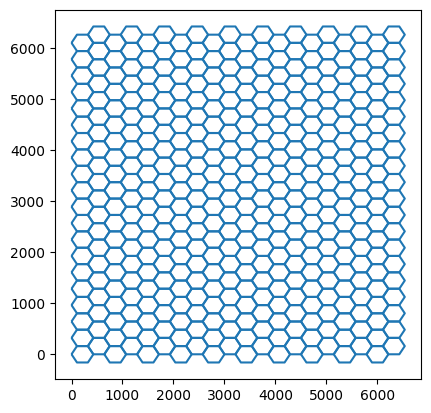

In [18]:
hexagonal_grid_gdf = make_hexagonal_grid(
    x_min=extent["x"][0],
    x_max=extent["x"][1],
    y_min=extent["y"][0],
    y_max=extent["y"][1],
    n_cells_x=20,
    n_cells_y=20,
)
hexagonal_grid_gdf.boundary.plot()

In [19]:
sdata["hexagonal_grid"] = hexagonal_grid_gdf

### Aggregate the nuclei into the grids

/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:105: UserWarning: Key `checkboard_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_k

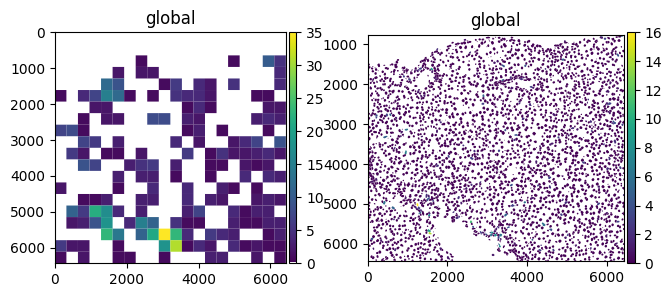

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")

(
    sdata.aggregate(values="nucleus_boundaries", by="checkboard_grid", value_key="Adgre1")
    .pl.render_shapes("checkboard_grid", color="Adgre1", cmap=new_cmap)
    .pl.show(ax=axs[0])
)
sdata.pl.render_shapes("nucleus_boundaries", color="Adgre1").pl.show(ax=axs[1])

/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:105: UserWarning: Key `hexagonal_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_ke

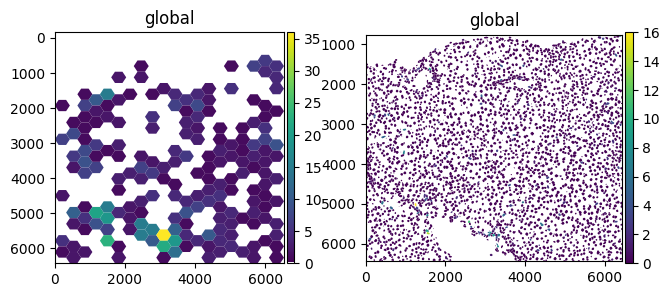

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")

(
    sdata.aggregate(values="nucleus_boundaries", by="hexagonal_grid", value_key="Adgre1")
    .pl.render_shapes("hexagonal_grid", color="Adgre1", cmap=new_cmap)
    .pl.show(ax=axs[0])
)
sdata.pl.render_shapes("nucleus_boundaries", color="Adgre1").pl.show(ax=axs[1])

## Further topics

Here are some extra details on the usage of `aggregate()`.

### Aggregating data from different locations

The `aggregate()` API can be used to aggregate variables (`var`) from `X` of the table, but also from the `obs` columns and from columns of `GeoDataFrame`/`DaskDataFrame` objects. Here are some examples.

#### Aggregating from `var`

This is the case that we saw above, but let's see it recapped here.

In [22]:
sdata["table"].var_names

Index(['Acta2', 'Adamtsl2', 'Adgre1', 'Adgrg6', 'Atp6v0d2', 'Axl', 'C5ar1',
       'Ccr2', 'Ccr7', 'Cd14', 'Cd19', 'Cd207', 'Cd209a', 'Cd36', 'Cd3e',
       'Cd5l', 'Cd79a', 'Cd9', 'Chil3', 'Clec10a', 'Clec4f', 'Clec9a', 'Clic5',
       'Col1a1', 'Colec11', 'Cox6a2', 'Cx3cr1', 'Cxcl12', 'Cyp2e1', 'Dcn',
       'Des', 'Dpt', 'Epcam', 'F13a1', 'Fcgr1', 'Flt3', 'Flt4', 'Fn1', 'Folr2',
       'Gdf15', 'Ghr', 'Gja5', 'Gls2', 'Glul', 'Gpnmb', 'Grip1', 'Hal', 'Hgf',
       'Igfbp3', 'Itgae', 'Itgax', 'Itgb7', 'Krt19', 'Lgr5', 'Lhx6', 'Lilra5',
       'Lpl', 'Lyve1', 'Mafb', 'Marco', 'Mfap4', 'Mgl2', 'Mmp12', 'Mmrn1',
       'Msln', 'Myh11', 'Ncam1', 'Ngfr', 'Nrxn1', 'Olfml3', 'Pck1', 'Pdgfra',
       'Pdgfrb', 'Pecam1', 'Plpp1', 'Prox1', 'Reln', 'Rspo3', 'Sds', 'Sept3',
       'Siglech', 'Sirpa', 'Slc40a1', 'Sox9', 'Spn', 'Spon2', 'Spp1', 'Stab2',
       'Svep1', 'Timd4', 'Tmem119', 'Trem2', 'Upk3b', 'Vsig4', 'Vwf', 'Wnt2',
       'Wnt9b', 'Wt1', 'Xcr1'],
      dtype='object')

The table annotates the nucleus boundaries, as we can see from this:

In [23]:
sdata.get_annotated_regions(sdata["table"])

'nucleus_boundaries'

Index(['Acta2'], dtype='object')


/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:105: UserWarning: Key `hexagonal_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_ke

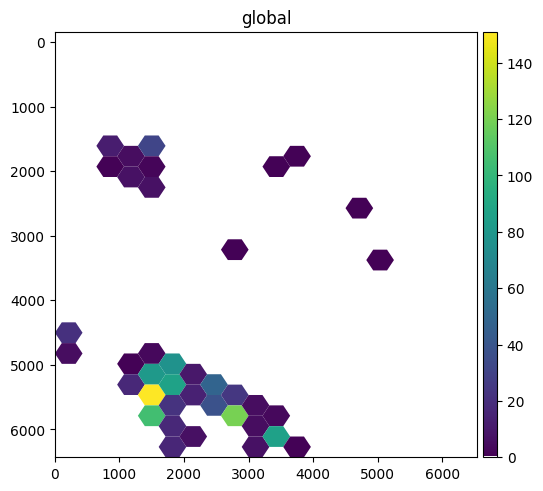

In [24]:
aggregated = sdata.aggregate(values="nucleus_boundaries", by="hexagonal_grid", value_key="Acta2")
print(aggregated["table"].var_names)
aggregated.pl.render_shapes("hexagonal_grid", color="Acta2", cmap=new_cmap).pl.show()

#### Aggregation from `obs`

In [25]:
sdata["table"].obs

,cell_ID,fov_labels,annotation
0,18,nucleus_boundaries,Kupffer cells
1,19,nucleus_boundaries,Other immunecells
2,32,nucleus_boundaries,Hepatocytes
3,33,nucleus_boundaries,Fibroblast
4,34,nucleus_boundaries,Fibroblast
...,...,...,...
3370,7680,nucleus_boundaries,Hepatocytes
3371,7694,nucleus_boundaries,Hepatocytes
3372,7708,nucleus_boundaries,Hepatocytes
3373,7723,nucleus_boundaries,Hepatocytes


Index(['B cells', 'Cholangiocytes', 'Fibroblast', 'Hepatocytes',
       'Kupffer cells', 'LSEC Central', 'LSEC Portal', 'Other immunecells',
       'stellate', 'unknown_celltype'],
      dtype='object')


/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:453: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated = joined.groupby([INDEX, vk])[ONES_COLUMN].agg(agg_func).reset_index()
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region

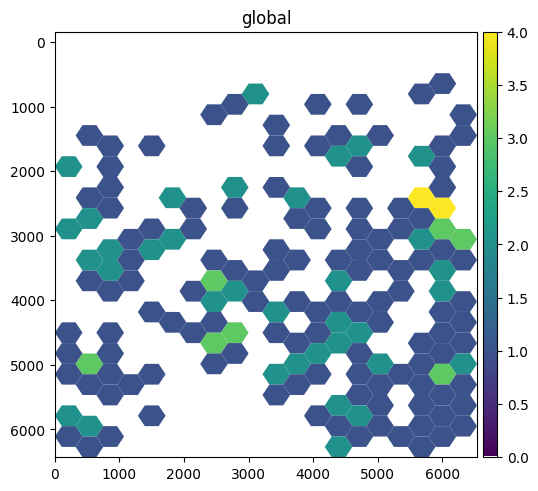

In [26]:
aggregated = sdata.aggregate(values="nucleus_boundaries", by="hexagonal_grid", value_key="annotation")
print(aggregated["table"].var_names)
aggregated.pl.render_shapes("hexagonal_grid", color="Kupffer cells", cmap=new_cmap).pl.show()

#### Aggregation from a `GeoDataFrame` column

Let's add a new column to the `GeoDataFrame`.

In [27]:
sdata["nucleus_boundaries"]["area"] = sdata["nucleus_boundaries"].geometry.area
sdata["nucleus_boundaries"]

,geometry,area
cell_ID,,
99,"POLYGON ((6277 798, 6277 799, 6272 799, 6272 8...",399.0
142,"POLYGON ((6427 6123, 6423 6123, 6423 6124, 641...",847.0
208,"POLYGON ((3747 858, 3747 859, 3746 859, 3746 8...",90.0
235,"POLYGON ((752 6144, 752 6145, 763 6145, 763 61...",11.0
336,"POLYGON ((5174 935, 5174 936, 5172 936, 5172 9...",508.0
...,...,...
7652,"POLYGON ((1094 6028, 1094 6029, 1091 6029, 109...",3257.0
7680,"POLYGON ((1324 6063, 1324 6064, 1320 6064, 132...",2997.0
7694,"POLYGON ((1692 6063, 1692 6064, 1686 6064, 168...",3052.0


Index(['area'], dtype='object')


/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:105: UserWarning: Key `hexagonal_grid` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_ke

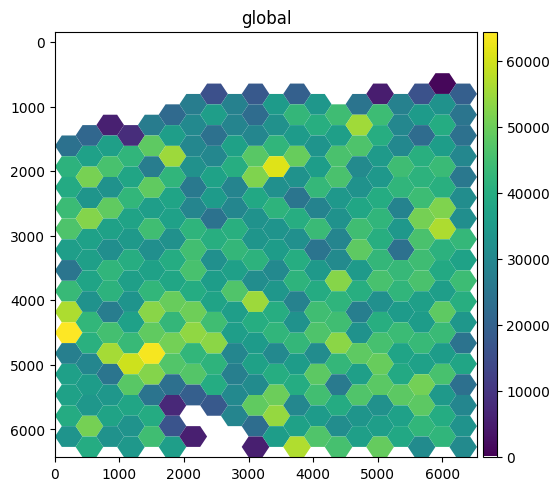

In [30]:
aggregated = sdata.aggregate(values="nucleus_boundaries", by="hexagonal_grid", value_key="area")
print(aggregated["table"].var_names)
aggregated.pl.render_shapes("hexagonal_grid", color="area", cmap=new_cmap).pl.show()

### `spatialdata.aggregate()` (function) vs `SpatialData.aggregate()` (method)

Above we used the `aggregate()` method of `SpatialData`. The function version is equivalent, with the difference that the method conveniently fills in eventually missing values of `values_sdata` and `by_sdata` with `self`.

So these two calls are equivalent:

In [32]:
res0 = sdata.aggregate(values="nucleus_boundaries", by="hexagonal_grid", value_key="Acta2")

/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


In [33]:
from spatialdata import aggregate

res1 = aggregate(
    values_sdata=sdata, by_sdata=sdata, values="nucleus_boundaries", by="hexagonal_grid", value_key="Acta2"
)

/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


In [36]:
from spatialdata.testing import assert_spatial_data_objects_are_identical

assert_spatial_data_objects_are_identical(res0, res1)

One can also directly pass to `values` or `by` a `SpatialElement`. So also this is an equivalent call, except for the fact that now the string `hexagonal_grid` is never passed to `aggregate()`, so a default name for the name of the resulting `SpatialElement` will be used.

In [39]:
res2 = aggregate(
    values_sdata=sdata,
    values="nucleus_boundaries",
    by=sdata["hexagonal_grid"],
    value_key="Acta2",
)
res2

/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


SpatialData object
├── Shapes
│     └── 'by': GeoDataFrame shape: (400, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (400, 1)
with coordinate systems:
    ▸ 'global', with elements:
        by (Shapes)

In [40]:
from anndata.tests.helpers import assert_equal

assert_equal(res0["table"].X, res2["table"].X)

In [41]:
res0["table"].obs

,instance_id,region
0,0,hexagonal_grid
1,1,hexagonal_grid
2,2,hexagonal_grid
3,3,hexagonal_grid
4,4,hexagonal_grid
...,...,...
395,395,hexagonal_grid
396,396,hexagonal_grid
397,397,hexagonal_grid
398,398,hexagonal_grid


In [43]:
res2["table"].obs

,instance_id,region
0,0,by
1,1,by
2,2,by
3,3,by
4,4,by
...,...,...
395,395,by
396,396,by
397,397,by
398,398,by


To conclude, the notebook covers the main anspect of the aggregation operation. Please refer to the API documentation for a complete technical description of all the parameters.